# Aim

Get tip-tilt atmospheres working once and for all.
maybe: Implement the Gerchberg-Saxton Algorithm for phase retrieval from intensity information.

In [3]:
# imports and setup

import sys
sys.path.append("..")
from hcipy.hcipy import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage

pupil_size = 16
focal_samples = 8 # samples per lambda over D
focal_width = 8 # half the number of lambda over Ds
focal_size = 2 * focal_samples * focal_width
D = 1
wavelength = 500e-9 # meter
k = 2 * np.pi / wavelength # not necessary! zernikes were already normalized to this = 1.
pupil_grid = make_pupil_grid(pupil_size, D)
focal_grid = make_focal_grid_from_pupil_grid(pupil_grid, focal_samples, focal_width, wavelength=wavelength)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
aperture = circular_aperture(D)(pupil_grid)
fried_parameter = 0.2 # meter
outer_scale = 20 # meter
velocity = 10 # meter/sec
Cn_squared = Cn_squared_from_fried_parameter(fried_parameter, wavelength)
layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared, outer_scale, velocity)

In [38]:
# generate single-unit TT and propagate it
tt = [zernike(*ansi_to_zernike(i), D)(pupil_grid) for i in (1, 2)]
tt_weights = (4, 4) # number of lambda-over-Ds I want to move the CM
scale = focal_samples / 4.86754191 # magic number to normalize to around one lambda-over-D
tt_wfs = [Wavefront(aperture * np.exp(1j * w * z * scale), wavelength) for w, z in zip(tt_weights, tt)]
tt_imgs = [prop(wf).intensity for wf in tt_wfs]
tt_imgs_ab = [prop(layer(wf)).intensity for wf in tt_wfs]

In [39]:
def center_of_mass(f):
    # takes in a Field, returns its CM.
    s = f.grid.shape[0]
    x, y = (n.flatten() for n in np.meshgrid(np.linspace(-s/2, s/2-1, s), np.linspace(-s/2, s/2-1, s)))
    return np.round(np.array((sum(f*x), sum(f*y)))/sum(f), 3)

# unaberrated single-unit pure TT
for i in tt_imgs:
    print(center_of_mass(i))
    
print('\n')
# aberrated single-unit pure TT
for i in tt_imgs_ab:
    print(center_of_mass(i))

[-0.    31.739]
[31.739 -0.   ]


[ 5.347 33.337]
[30.932  7.909]


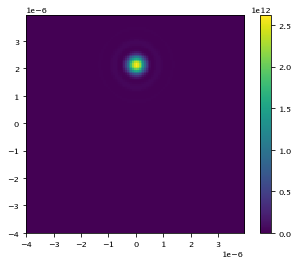

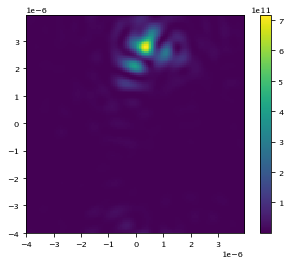

In [41]:
imshow_field(tt_imgs[0])
plt.colorbar()
plt.show()
imshow_field(tt_imgs_ab[0])
plt.colorbar()
plt.show()